# Training an FNO on Darcy-Flow
In this example, we demonstrate how to use the small Darcy-Flow example we ship with the package to train a Fourier Neural Operator.

Note that this dataset is much smaller than one we would use in practice. The small Darcy-flow is an example built to be trained on a CPU in a few seconds, whereas normally we would train on one or multiple GPUs.

In [2]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.data.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

device = 'cuda'

Let’s load the small Darcy-flow dataset.

In [3]:
train_loader, test_loaders, data_processor = load_darcy_flow_small(
        n_train=1000, batch_size=32,
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
)
data_processor = data_processor.to(device)

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 50 samples 


C:\Users\Evave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\neuralop\data\datasets\pt_dataset.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub fo

In [16]:
print(train_loader)
print(test_loaders)

{16: <torch.utils.data.dataloader.DataLoader object at 0x0000027739C07A50>, 32: <torch.utils.data.dataloader.DataLoader object at 0x0000027739598550>}


We create a simple FNO model

In [4]:
model = FNO(n_modes=(16, 16),
             in_channels=1,
             out_channels=1,
             hidden_channels=32,
             projection_channel_ratio=2)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 1192801 parameters.


## Training setup
Create the optimizer

In [5]:
optimizer = AdamW(model.parameters(),
                                lr=8e-3,
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [6]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

## Training the model

In [7]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([32, 32, 16, 9]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
          (1): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 

Create the trainer:

In [8]:
trainer = Trainer(model=model, n_epochs=20,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=False,
                  eval_interval=3,
                  use_distributed=False,
                  verbose=True)

Then train the model on our small Darcy-Flow dataset:

In [9]:
trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler,
              regularizer=False,
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 1000 samples
Testing on [50, 50] samples         on resolutions [16, 32].
Raw outputs of shape torch.Size([32, 1, 16, 16])
[0] time=1.91, avg_loss=0.5884, train_err=18.3866
Eval: 16_h1=0.3848, 16_l2=0.2621, 32_h1=0.5600, 32_l2=0.2726
[3] time=0.36, avg_loss=0.2178, train_err=6.8065
Eval: 16_h1=0.2216, 16_l2=0.1546, 32_h1=0.5047, 32_l2=0.1943
[6] time=0.33, avg_loss=0.1881, train_err=5.8768
Eval: 16_h1=0.2326, 16_l2=0.1578, 32_h1=0.4891, 32_l2=0.1913
[9] time=0.31, avg_loss=0.1679, train_err=5.2473
Eval: 16_h1=0.2514, 16_l2=0.1761, 32_h1=0.4841, 32_l2=0.1934
[12] time=0.33, avg_loss=0.1391, train_err=4.3474
Eval: 16_h1=0.2162, 16_l2=0.1408, 32_h1=0.5423, 32_l2=0.1867
[15] time=0.31, avg_loss=0.1272, train_err=3.9753
Eval: 16_h1=0.1928, 16_l2=0.1149, 32_h1=0.5211, 32_l2=0.1605
[18] time=0.32, avg_loss=0.1122, train_err=3.5057
Eval: 16_h1=0.2105, 16_l2=0.1282, 32_h1=0.5398, 32_l2=0.1741


{'train_err': 3.35686974786222,
 'avg_loss': 0.10741983193159103,
 'avg_lasso_loss': None,
 'epoch_train_time': 0.33307729999069124}

store the model

In [14]:
torch.save(model, r"E:\UCLCS\UCL Project\Neural Operator\COMP0031-Model-Compression-on-Neural-Operator\models\darcy_small.pth")

## Visualizing predictions
Let’s take a look at what our model’s predicted outputs look like. Again note that in this example, we train on a very small resolution for a very small number of epochs. In practice, we would train at a larger resolution, on many more samples.

C:\Users\Evave\AppData\Local\Temp\ipykernel_26948\2680554711.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


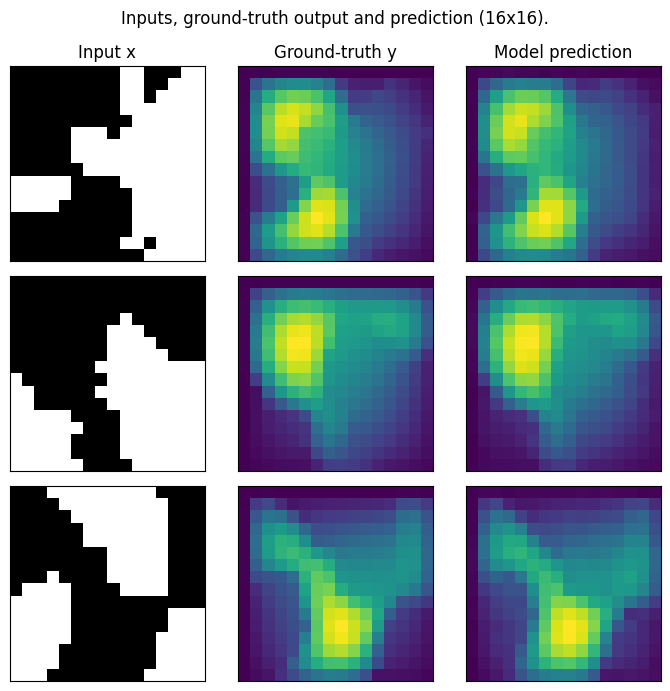

In [30]:
test_samples = test_loaders[16].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0].cpu(), cmap='gray')
    if index == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.cpu().squeeze())
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.cpu().squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction (16x16).', y=0.98)
plt.tight_layout()
fig.show()

### Zero-shot super-evaluation
In addition to training and making predictions on the same input size, the FNO’s invariance to the discretization of input data means we can natively make predictions on higher-resolution inputs and get higher-resolution outputs.

C:\Users\Evave\AppData\Local\Temp\ipykernel_26948\1530896810.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


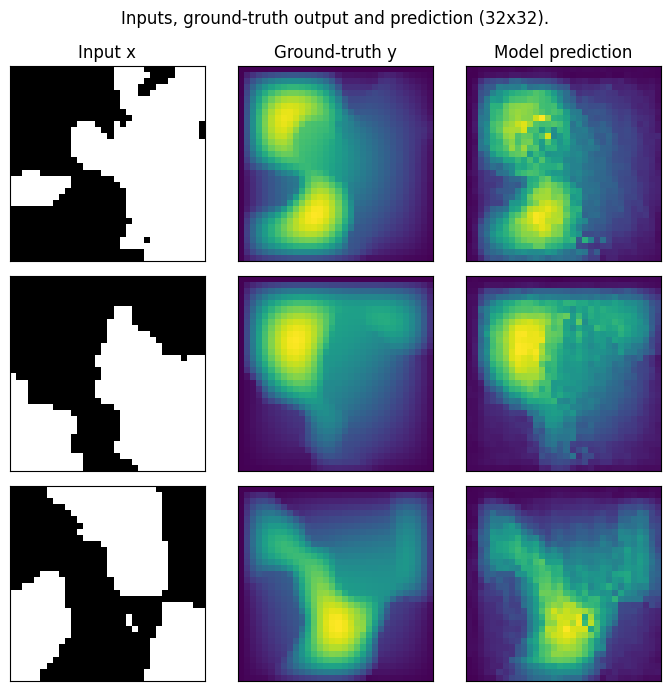

In [32]:
test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0].cpu(), cmap='gray')
    if index == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.cpu().squeeze())
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.cpu().squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction (32x32).', y=0.98)
plt.tight_layout()
fig.show()

We only trained the model on data at a resolution of 16x16, and with no modifications or special prompting, we were able to perform inference on higher-resolution input data and get higher-resolution predictions! In practice, we often want to evaluate neural operators at multiple resolutions to track a model’s zero-shot super-evaluation performance throughout training. That’s why many of our datasets, including the small Darcy-flow we showcased, are parameterized with a list of test_resolutions to choose from.

However, as you can see, these predictions are noisier than we would expect for a model evaluated at the same resolution at which it was trained. Leveraging the FNO’s discretization-invariance, there are other ways to scale the outputs of the FNO to train a true super-resolution capability.